# Final Assessment Scratch Pad

## Instructions

1. Please use only this Jupyter notebook to work on your model, and **do not use any extra files**. If you need to define helper classes or functions, feel free to do so in this notebook.
2. This template is intended to be general, but it may not cover every use case. The sections are given so that it will be easier for us to grade your submission. If your specific use case isn't addressed, **you may add new Markdown or code blocks to this notebook**. However, please **don't delete any existing blocks**.
3. If you don't think a particular section of this template is necessary for your work, **you may skip it**. Be sure to explain clearly why you decided to do so.

## Report

**[TODO]**

Please provide a summary of the ideas and steps that led you to your final model. Someone reading this summary should understand why you chose to approach the problem in a particular way and able to replicate your final model at a high level. Please ensure that your summary is detailed enough to provide an overview of your thought process and approach but also concise enough to be easily understandable. Also, please follow the guidelines given in the `main.ipynb`.

This report should not be longer than **1-2 pages of A4 paper (up to around 1,000 words)**. Marks will be deducted if you do not follow instructions and you include too many words here. 

**[DELETE EVERYTHING FROM THE PREVIOUS TODO TO HERE BEFORE SUBMISSION]**

##### Overview
**[TODO]**

##### 1. Descriptive Analysis
**[TODO]**

##### 2. Detection and Handling of Missing Values
**[TODO]**

##### 3. Detection and Handling of Outliers
**[TODO]**

##### 4. Detection and Handling of Class Imbalance 
**[TODO]**

##### 5. Understanding Relationship Between Variables
**[TODO]**

##### 6. Data Visualization
**[TODO]** 
##### 7. General Preprocessing
**[TODO]**
 
##### 8. Feature Selection 
**[TODO]**

##### 9. Feature Engineering
**[TODO]**

##### 10. Creating Models
**[TODO]**

##### 11. Model Evaluation
**[TODO]**

##### 12. Hyperparameters Search
**[TODO]**

##### Conclusion
**[TODO]**

---

# Workings (Not Graded)

You will do your working below. Note that anything below this section will not be graded, but we might counter-check what you wrote in the report above with your workings to make sure that you actually did what you claimed to have done. 

## Import Packages

Here, we import some packages necessary to run this notebook. In addition, you may import other packages as well. Do note that when submitting your model, you may only use packages that are available in Coursemology (see `main.ipynb`).

In [45]:
import pandas as pd
import os
import numpy as np
from util import show_images, dict_train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# DTL libraries
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets, transforms

# Verify boosted pytorch version
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Load Dataset

The dataset provided is multimodal and contains two components, images and tabular data. The tabular dataset `tabular.csv` contains $N$ entries and $F$ columns, including the target feature. On the other hand, the image dataset `images.npy` is of size $(N, H, W)$, where $N$, $H$, and $W$ correspond to the number of data, image width, and image height, respectively. Each image corresponds to the data in the same index of the tabular dataset. These datasets can be found in the `data/` folder in the given file structure.

A code snippet that loads and displays some of the data is provided below.

### Load Tabular Data

In [46]:
df = pd.read_csv(os.path.join('data', 'tabular.csv'))

### Load Image Data

Shape: (357699, 8, 8)


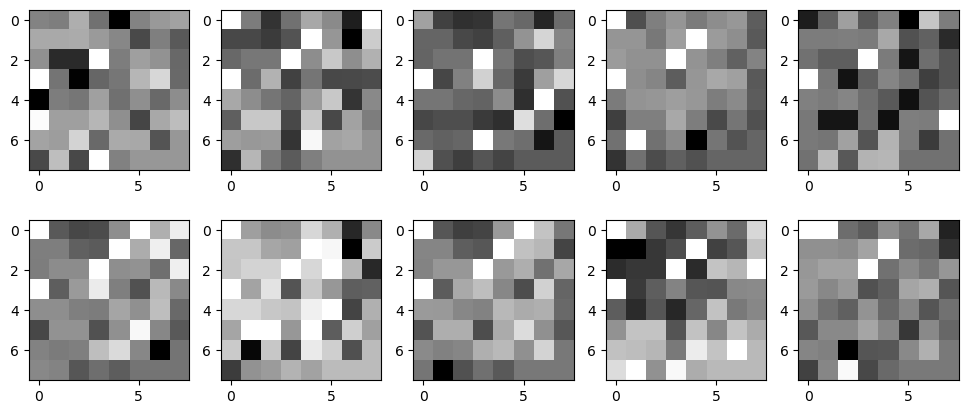

In [47]:
with open(os.path.join('data', 'images.npy'), 'rb') as f:
    images = np.load(f)
    
print('Shape:', images.shape)
show_images(images[:10], n_row=2, n_col=5, figsize=[12,5])

### Helper functions

In [48]:
def plot_graph(df: pd.DataFrame):
    label = df.columns

    # get the data
    data = df.values

    # plot the distribution of each column
    # Set up the subplots
    num_rows = 15
    num_cols = 4
    _, axes = plt.subplots(num_rows, num_cols, figsize=(60, 60))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot the distribution of each column
    for i, col in enumerate(df.columns):
        ax = axes[i]
        
        if df[col].dtype == 'object':
            sns.countplot(x=col, data=df, ax=ax)
        else:
            sns.histplot(df[col], kde=True, ax=ax)
        
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

## Data Exploration & Preparation

### 1. Descriptive Analysis

In [49]:
# Describing the data
print(f"Shape of the tabular dataset: {df.shape}")
print(f"Shape of the image dataset: {images.shape}")

Shape of the tabular dataset: (357699, 61)
Shape of the image dataset: (357699, 8, 8)


### Spliting the dataset

In [50]:
# Copy the main df and image ndarray
df_copy = df.copy(deep=True)
images_copy = images.copy()

# Exclude target column
X_columns = [col for col in df_copy.columns if col != 'target']

# Create X_dict and y
X_dict = {
    'tabular': df_copy[X_columns],
    'images': images_copy
}
y = df_copy['target']

# Split the data
X_dict_train, y_train, X_dict_test, y_test = dict_train_test_split(X_dict, y, ratio=0.9)

print(f"Shape of X_dict_train['tabular']: {X_dict_train['tabular'].shape}")
print(f"Shape of X_dict_train['images']: {X_dict_train['images'].shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_dict_test['tabular']: {X_dict_test['tabular'].shape}")
print(f"Shape of X_dict_test['images']: {X_dict_test['images'].shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_dict_train['tabular']: (321929, 60)
Shape of X_dict_train['images']: (321929, 8, 8)
Shape of y_train: (321929,)
Shape of X_dict_test['tabular']: (35770, 60)
Shape of X_dict_test['images']: (35770, 8, 8)
Shape of y_test: (35770,)


### 2. Detection and Handling of Missing Values

In [51]:
# Remove missing data that are completely missing or has 2 or more missing values
target_df = X_dict_train['tabular'].copy(deep=True)
print(f"before: {target_df.shape}")

# Drop na columns with more than threshold percent of missing values
threshold = 0.5
target_df = target_df.dropna(axis=1, thresh=threshold * len(target_df))

print(f"shape: {target_df.shape}")
X_dict_train['tabular'] = target_df

before: (321929, 60)
shape: (321929, 57)


### 3. Detection and Handling of Outliers

In [52]:
# Remove outliers (> 3S.D.)
target_df = X_dict_train['tabular'].copy(deep=True)
target_y_train = y_train.copy()
target_images = X_dict_train['images'].copy()
print(f"Before: {target_df.shape}")

standard_deviations = 3
for col in target_df.columns:
    if target_df[col].dtype == np.object_:
        continue
    
    # Removing outliers using z-score and std
    target_df = target_df[
        ((target_df[col] - target_df[col].mean()) / target_df[col].std()).abs() < standard_deviations
    ]

# Drop the rest of the na values
target_df.dropna(inplace=True)

# Applying the indices to the images and y train
target_images = target_images[target_df.index]
y_train = y_train[target_df.index]

print(f"After: {target_df.shape}, {target_images.shape}, {y_train.shape}")

# Update the relevant datasets
X_dict_train['tabular'] = target_df
X_dict_train['images'] = target_images
y_train = y_train

Before: (321929, 57)
After: (117123, 57), (117123, 8, 8), (117123,)


### 4. Detection and Handling of Class Imbalance

### 5. Understanding Relationship Between Variables

### 6. Data Visualization

/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

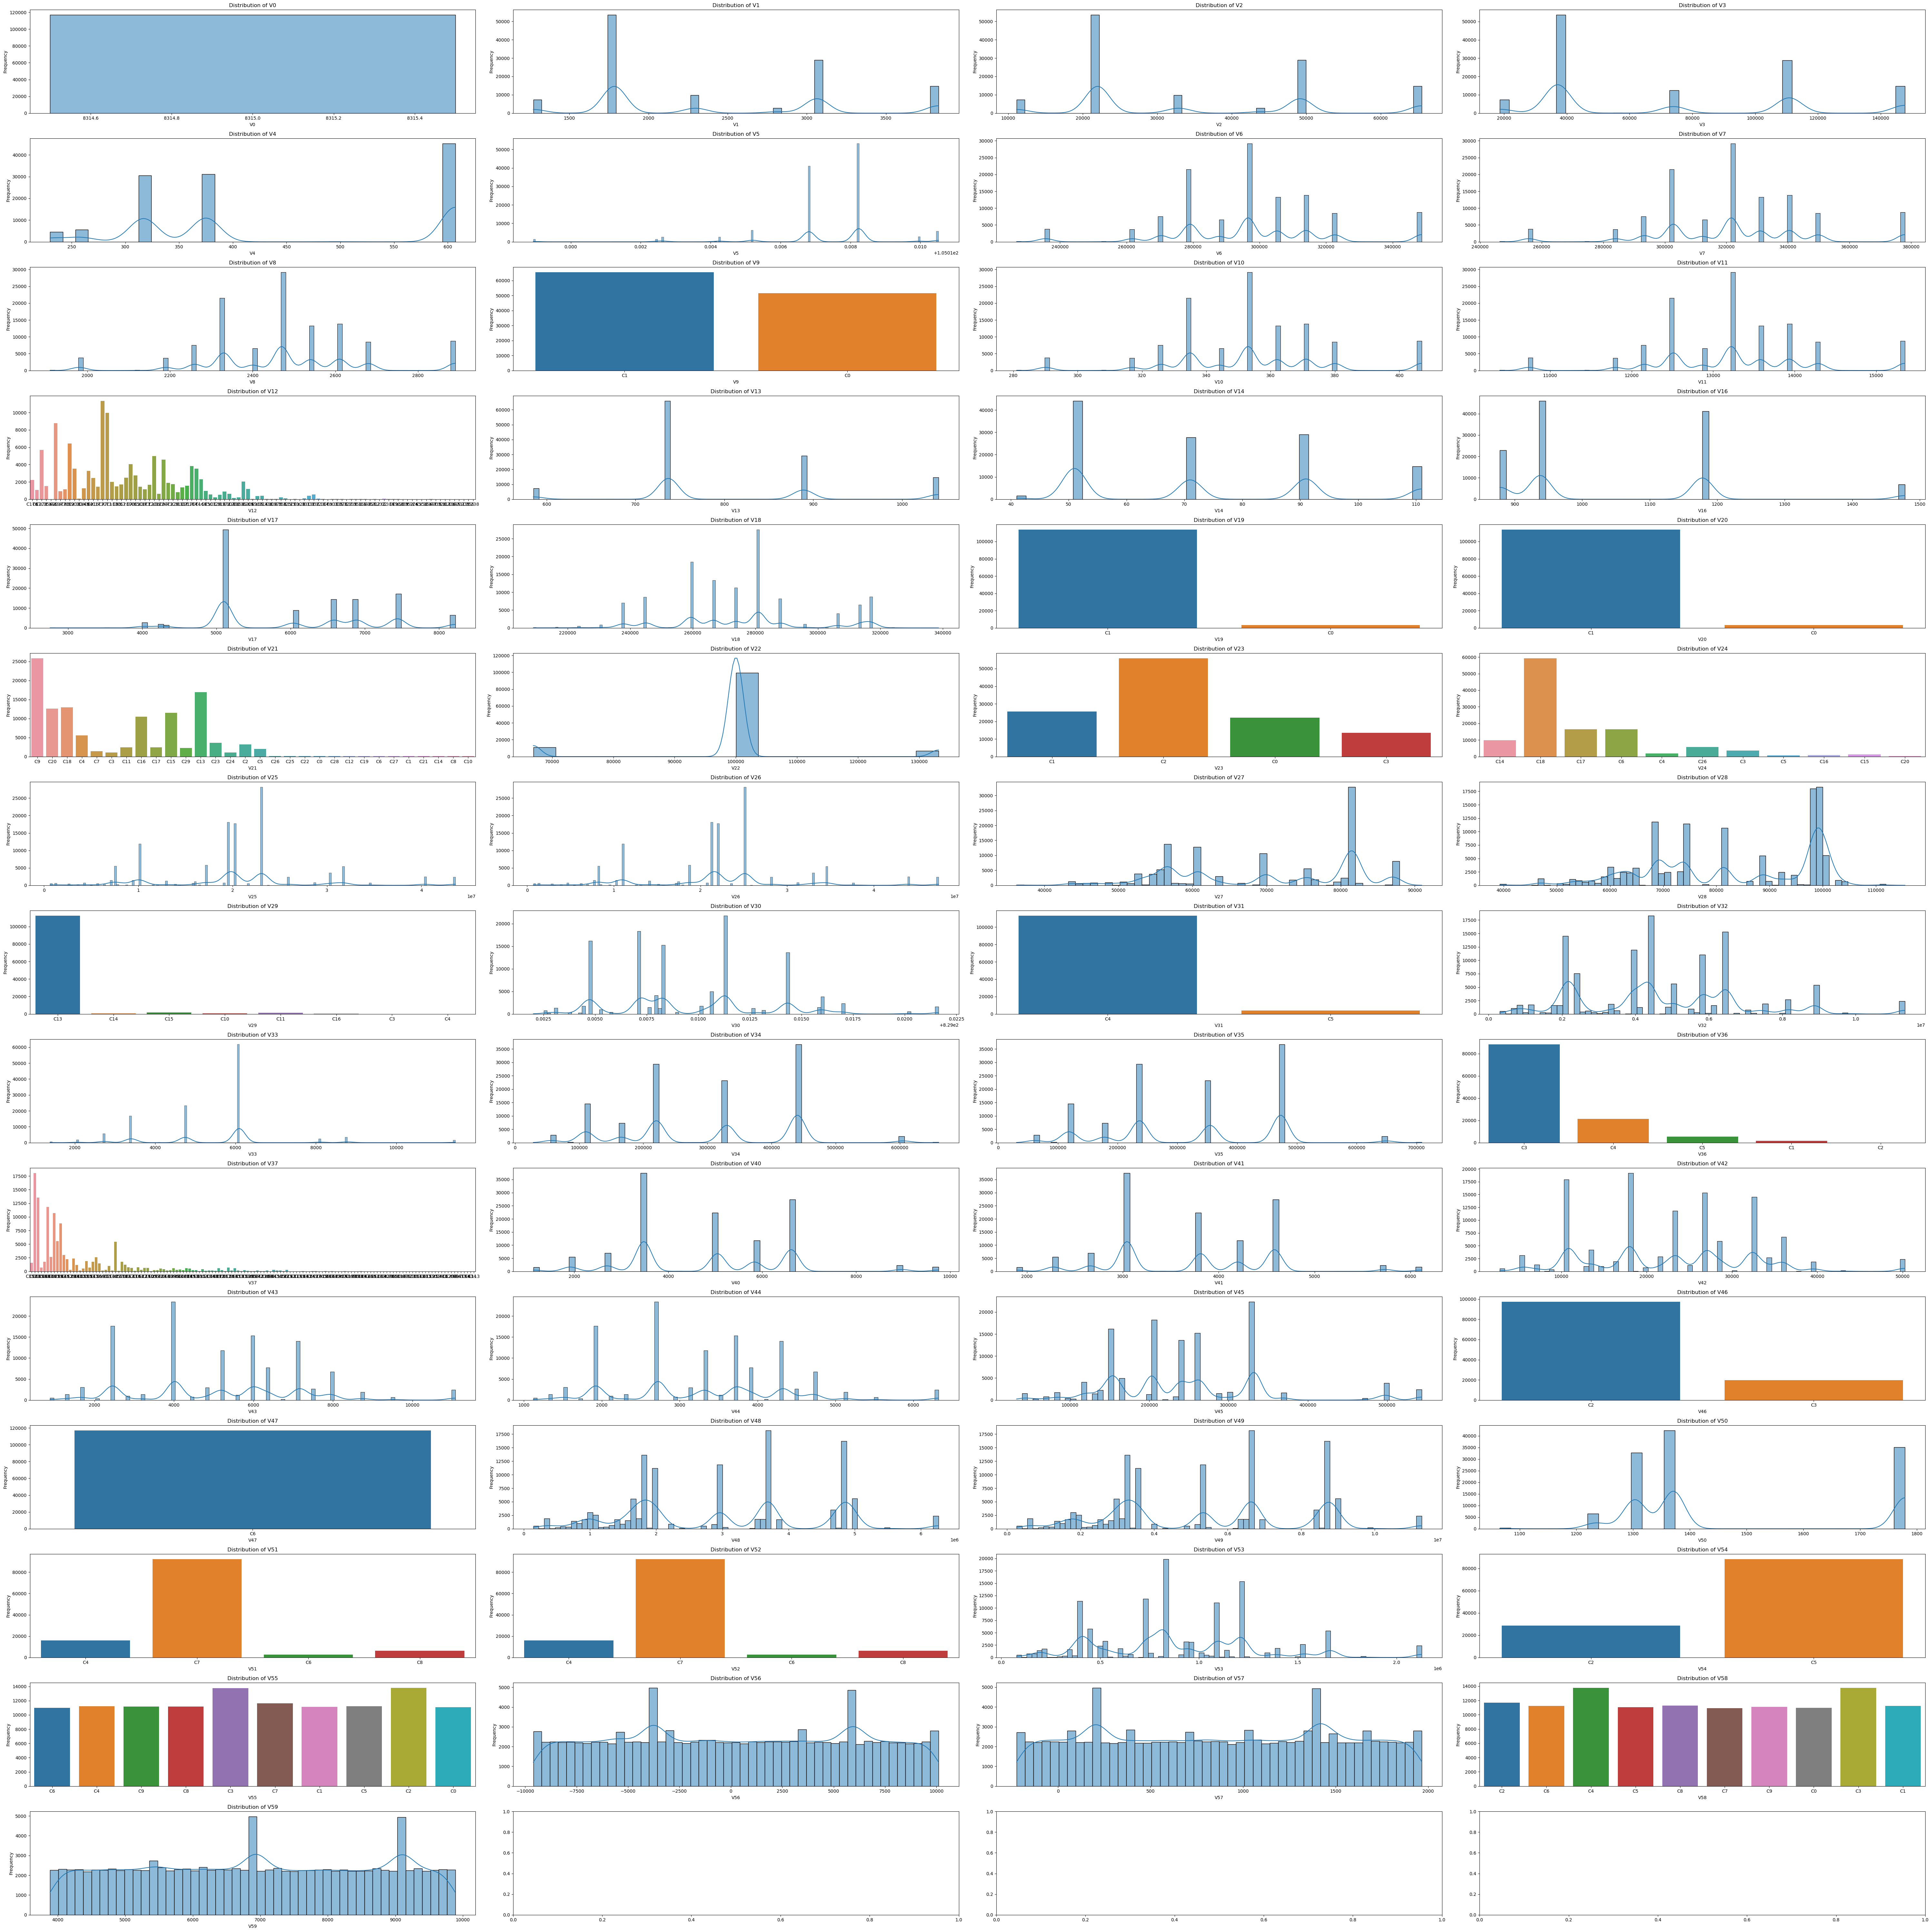

In [9]:
target_df = X_dict_train['tabular'].copy(deep=True)
plot_graph(target_df)

## Data Preprocessing

### 7. General Preprocessing

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Define categorical and numerical features (adjust these based on your dataset)
categorical_features = [col for col in X_dict_train['tabular'].columns if X_dict_train['tabular'][col].dtype == 'object']
numerical_features = [col for col in X_dict_train['tabular'].columns if X_dict_train['tabular'][col].dtype != 'object']

tabular_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Tabular data processing
X_tabular_train = tabular_preprocessor.fit_transform(X_dict_train['tabular'])
X_tabular_test = tabular_preprocessor.transform(X_dict_test['tabular'])

print(f"Shape of X_tabular_train: {X_tabular_train.shape}")
print(f"Shape of X_tabular_test: {X_tabular_test.shape}")

X_dict_train['tabular'] = X_tabular_train
X_dict_test['tabular'] = X_tabular_test

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### 8. Feature Selection

In [54]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

target_df = X_dict_train['tabular'].copy()
y_df = y_train.copy()
print(f"Before: {target_df.shape}")

# Select features using LassoCV
clf = LassoCV().fit(target_df, y_df)
m = SelectFromModel(clf, prefit=True)

target = m.transform(target_df)

print(target.shape)

# Update the relevant datasets
X_dict_train['tabular'] = target

Before: (117123, 57)


/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


(117123, 27)


### 9. Feature Engineering

## Modeling & Evaluation

### 10. Creating models

In [55]:
"""
Using sklearn hist gradient boosting regressor
"""

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train = X_dict_train['tabular']
X_test = X_dict_test['tabular']

# Create and train the HistGradientBoostingRegressor
regressor = HistGradientBoostingRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(mse)

/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


ValueError: X has 57 features, but HistGradientBoostingRegressor is expecting 27 features as input.

In [17]:
"""
Creating a simple torch neural network that deals with tabular data
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RegressionModel(nn.Module):
    def __init__(self, input_dim, classes):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

X_train = X_dict_train['tabular']
X_test = X_dict_test['tabular']
y_train = y_train
y_test = y_test

# training
model = RegressionModel(X_train.shape[1], 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train = torch.tensor(torch.from_numpy(X_train)) if not torch.is_tensor(X_train) else X_train
y_train = torch.FloatTensor(y_train.values) if not torch.is_tensor(y_train) else y_train

# Convert to tensors
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
epochs = 100
for epoch in range(epochs):

    model.train()
    total_loss = 0.0
    num_batches = 0

    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

        # Print statistics
        total_loss += loss.item()
        num_batches += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Training loss: {total_loss / num_batches}")

/var/folders/qx/pggnf_kj5c97gbs7jkp83p3h0000gn/T/ipykernel_32596/4263314361.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(torch.from_numpy(X_train)) if not torch.is_tensor(X_train) else X_train
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kurtyjlee/anaconda3/envs/cs2109s-boosted/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to i

Epoch 0 - Training loss: 6529.935452072168
Epoch 10 - Training loss: 5920.304775935974
Epoch 20 - Training loss: 5921.346276875469
Epoch 30 - Training loss: 5912.964062660005
Epoch 40 - Training loss: 5913.036496556697
Epoch 50 - Training loss: 5909.177027087209
Epoch 60 - Training loss: 5910.201409882108
Epoch 70 - Training loss: 5908.193415643347
Epoch 80 - Training loss: 5906.12950280115
Epoch 90 - Training loss: 5912.128620241458


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class RegressionModel(nn.Module):
    def __init__(self, input, classes):
        super(RegressionModel, self).__init__()

        # for tabular data
        self.fc1 = nn.Linear(input, 256)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(16, classes)

        # for image data
        # self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.flatten = nn.Flatten()
    
    def forward(self, tab):
        # x = img 
        # x = self.conv1(x)
        # x = self.pool(x)
        # x = self.flatten(x)
        x = tab
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = torch.cat((x, tab), dim=1)
        x = F.relu(self.fc3(x))

        return x

class Model:  
    """
    This class represents an AI model.
    """
    def __init__(self):
        """
        Constructor for Model class.
  
        Parameters
        ----------
        self : object
            The instance of the object passed by Python.
        """
        # TODO: Replace the following code with your own initialization code.
        self.model = None
        self.feature_col = None
        self.label_encoder = LabelEncoder()
        self.label_mapping = {}
        self.scaler = StandardScaler()
        # hyperparameters
        self.drop_accuracy = 0.5
        self.outlier_accuracy = 3
        self.epochs = 50
        self.batch_size = 256
        self.lr = 0.001
        self.k = 35

    def remove_outlier(self, outlier_index, parsed_data_two):
        hyper_param_outliers = outlier_index
        numerical_columns = parsed_data_two.select_dtypes(include=np.number).columns

        for col in numerical_columns:
            col_mean = parsed_data_two[col].mean()
            col_std = parsed_data_two[col].std()    
            parsed_data_three = parsed_data_two[np.abs((parsed_data_two[col] - col_mean) / col_std) < hyper_param_outliers]
        
        return parsed_data_three

    def fit(self, X_dict, y):
        """
        Train the model using the input data.
        
        Parameters
        ----------
        X_dict : dictionary with the following entries:
            - tabular: pandas Dataframe of shape (n_samples, n_features)
            - images: ndarray of shape (n_samples, height, width)
            Training data.
        y : pandas Dataframe of shape (n_samples,)
            Target values.
            
        Returns
        -------
        self : object
            Returns an instance of the trained model.
        """
        # TODO: Add your training code.

        x_tab = X_dict['tabular']

        # first drop of any columns more than (hyper_param)*100% missing values because it is not useful
        parsed_data = x_tab.copy(deep=True)
        parsed_data = parsed_data.dropna(axis=1, thresh=self.drop_accuracy*len(x_tab))

        # next drop rows with missing values in labels
        parsed_data_two = parsed_data.copy(deep=True)
        parsed_tabular_data = parsed_data_two.dropna(axis=0)
        y_parsed = y.copy(deep=True)[parsed_tabular_data.index]
       
        # remove outliers
        parsed_tabular_data = self.remove_outlier(self.outlier_accuracy, parsed_tabular_data)
        y_parsed = y_parsed[parsed_tabular_data.index]
        
        # conversion of categorical data to numerical data
        parsed_tabular_categorical = parsed_tabular_data.select_dtypes(include='object')



        for col in parsed_tabular_categorical.columns:
            parsed_tabular_data[col] = self.label_encoder.fit_transform(parsed_tabular_data[col])
        
        # store the label mapping for future use
        for col in parsed_tabular_categorical.columns:
            self.label_mapping[col] = dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))

        # normalising
        x_processed = self.scaler.fit_transform(parsed_tabular_data)
        x_processed = pd.DataFrame(x_processed, columns=parsed_tabular_data.columns)

        # using feature selection to find the most important features
        selector = SelectKBest(f_regression, k=self.k)
        selector.fit(x_processed, y_parsed)
        x_processed = x_processed[x_processed.columns[selector.get_support(indices=True)]]
        self.feature_col = x_processed.columns

        self.model = RegressionModel(x_processed.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # convert data to tensor
        x_processed = torch.tensor(x_processed.to_numpy(dtype=np.float32)) if not torch.is_tensor(x_processed) else x_processed
        y_parsed = torch.FloatTensor(y_parsed.values) if not torch.is_tensor(y_parsed) else y_parsed

        train_dataset = TensorDataset(x_processed, y_parsed)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0.0
            num_batches = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

            # print every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch: {epoch}, Loss: {total_loss/num_batches}')

    def predict(self, X_dict):
        """
        Use the trained model to make predictions.
        
        Parameters
        ----------
        X_dict : dictionary with the following entries:
            - tabular: pandas Dataframe of shape (n_samples, n_features)
            - images: ndarray of shape (n_samples, height, width)
            Input data.
            
        Returns
        -------
        pandas Dataframe of shape (n_samples,)
           Predicted target values per element in X_dict.
           
        """
        # TODO: Replace the following code with your own prediction code.
        x_tab = X_dict['tabular']
        x_tab_numerical = x_tab.select_dtypes(include=np.number)
        x_tab_categorical = x_tab.select_dtypes(include='object')
        # convert all possible categorical data to numerical data using the dictionary
        for col in x_tab_categorical.columns:
            x_tab_categorical[col] = x_tab_categorical[col].map(self.label_mapping[col])
        # convert all instances of 'object' type data to nan
        obj_cols = x_tab_categorical.select_dtypes(include='object').columns
        x_tab_categorical = x_tab_categorical.replace(obj_cols, np.nan)

        # merge the numerical and categorical data together based on the feature columns
        temp = np.empty((len(x_tab_numerical), len(self.feature_col)))
        for i, col in enumerate(self.feature_col):
            if col in x_tab_numerical.columns:
                temp[:, i] = x_tab_numerical[col]
            else:
                temp[:, i] = x_tab_categorical[col]
        x = temp

        # normalising
        x = self.scaler.fit_transform(x)

        y_pred = self.model(torch.tensor(x, dtype=torch.float32)).detach().numpy()
        # convert all nan in y_pred to mean
        y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))
        # increase the variance of the prediction by 100%
        return y_pred 

### 11. Model Evaluation

### 12. Hyperparameters Search